In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import networkx as nx
from scipy.stats import ttest_ind

# Eurovision Song Contest (ESC) Analysis

## Data Familiarization

In [148]:
# Get current directory
cwd = os.getcwd()
print(cwd)

c:\Users\mate1\OneDrive\Escritorio\Repository\Eurovision_Contest_Analysis


In [149]:
# Load data
df_votes = pd.read_csv('Data/votes.csv')
a = df_votes[df_votes['year'] == 2016]
a

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
39613,2016,final,al,ua,al,ua,6,6.0,0.0
39614,2016,final,al,au,al,au,24,12.0,12.0
39615,2016,final,al,ru,al,ru,14,7.0,7.0
39616,2016,final,al,bg,al,bg,12,8.0,4.0
39617,2016,final,al,se,al,se,3,3.0,0.0
...,...,...,...,...,...,...,...,...,...
41456,2016,semi-final-2,gb,si,gb,si,0,0.0,0.0
41457,2016,semi-final-2,gb,ie,gb,ie,9,7.0,2.0
41458,2016,semi-final-2,gb,al,gb,al,0,0.0,0.0
41459,2016,semi-final-2,gb,dk,gb,dk,0,0.0,0.0


In [150]:
# Get the initial and last years of the data
initial_year = df_votes['year'].min()
final_year = df_votes['year'].max()
print('Initial year:', initial_year)
print('Final year:', final_year)

Initial year: 1957
Final year: 2023


### Data Cleaning

In this work we are only interested in the final round.

In [151]:
# Get only the final round
df_final_round = df_votes[df_votes['round'] == 'final']

In [152]:
# Remove giving 0 points
df_final_round = df_final_round[df_final_round['total_points'] > 0]
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
6,1957,final,at,gb,at,gb,1,NaN,NaN
10,1957,final,be,nl,be,nl,5,NaN,NaN
11,1957,final,be,fr,be,fr,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51340,2023,final,wld,hr,wld,hr,3,3.0,NaN
51341,2023,final,wld,am,wld,am,8,8.0,NaN
51343,2023,final,wld,fr,wld,fr,1,1.0,NaN
51344,2023,final,wld,es,wld,es,2,2.0,NaN


In [153]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['ad' 'al' 'am' 'at' 'au' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cs' 'cy' 'cz'
 'de' 'dk' 'ee' 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is'
 'it' 'lt' 'lu' 'lv' 'ma' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt'
 'ro' 'rs' 'ru' 'se' 'si' 'sk' 'sm' 'tr' 'ua' 'wld' 'yu']
Number of countries: 53


In [154]:
# # Broadcast the Yugoslavia points to their actual countries
# broadcast = {
#     'yu': ['ba', 'hr', 'mk', 'rs', 'si'],
#     'cs': ['rs', 'me']
# }

# df_final_round['from_country_id'] = df_final_round['from_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round['to_country_id'] = df_final_round['to_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round.explode('from_country_id').explode('to_country_id')

In [155]:
# Dictionary with the real name of the countries
country_id_to_name = {
    'ad': 'Andorra',
    'al': 'Albania',
    'am': 'Armenia',
    'at': 'Austria',
    'au': 'Australia',
    'az': 'Azerbaijan',
    'ba': 'Bosnia and Herzegovina',
    'be': 'Belgium',
    'bg': 'Bulgaria',
    'by': 'Belarus',
    'ch': 'Switzerland',
    'cs': 'Serbia and Montenegro',  # Historical ID
    'cy': 'Cyprus',
    'cz': 'Czech Republic',
    'de': 'Germany',
    'dk': 'Denmark',
    'ee': 'Estonia',
    'es': 'Spain',
    'fi': 'Finland',
    'fr': 'France',
    'gb': 'United Kingdom',
    'ge': 'Georgia',
    'gr': 'Greece',
    'hr': 'Croatia',
    'hu': 'Hungary',
    'ie': 'Ireland',
    'il': 'Israel',
    'is': 'Iceland',
    'it': 'Italy',
    'lt': 'Lithuania',
    'lu': 'Luxembourg',
    'lv': 'Latvia',
    'ma': 'Morocco',
    'mc': 'Monaco',
    'md': 'Moldova',
    'me': 'Montenegro',
    'mk': 'North Macedonia',
    'mt': 'Malta',
    'nl': 'Netherlands',
    'no': 'Norway',
    'pl': 'Poland',
    'pt': 'Portugal',
    'ro': 'Romania',
    'rs': 'Serbia',
    'ru': 'Russia',
    'se': 'Sweden',
    'si': 'Slovenia',
    'sk': 'Slovakia',
    'sm': 'San Marino',
    'tr': 'Turkey',
    'ua': 'Ukraine',
    'wld': 'World',  # Possible placeholder for aggregated data
    'yu': 'Yugoslavia'  # Historical ID
}

In [156]:
df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
6,1957,final,at,gb,Austria,United Kingdom,1,NaN,NaN
10,1957,final,be,nl,Belgium,Netherlands,5,NaN,NaN
11,1957,final,be,fr,Belgium,France,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51340,2023,final,wld,hr,World,Croatia,3,3.0,NaN
51341,2023,final,wld,am,World,Armenia,8,8.0,NaN
51343,2023,final,wld,fr,World,France,1,1.0,NaN
51344,2023,final,wld,es,World,Spain,2,2.0,NaN


### Number of Participations

In [157]:
# Get the number of participations of each country

# Combine all country IDs into a single column with the corresponding year
participations = pd.concat([
    df_final_round[['year', 'from_country']].rename(columns={'from_country': 'country'}),
    df_final_round[['year', 'to_country']].rename(columns={'to_country': 'country'}),
])

# Explode the lists into individual rows
participations = participations.explode('country')

# Drop duplicates to ensure each country-year combination is only counted once
participations = participations.drop_duplicates()

# Count the number of unique years each country participated
participation_counts = participations.groupby('country')['year'].nunique()

# Convert the result to a DataFrame
participation_counts = participation_counts.reset_index()
participation_counts.columns = ['country', 'participation_count']

# Change the country IDs to their full names
# participation_counts['country_name'] = participation_counts['country_id'].map(country_id_to_name)

# Represent in a table the number of participations of each country with their complete name
participation_counts = participation_counts.sort_values('participation_count', ascending=False)
participation_counts[['country', 'participation_count']]


,country,participation_count
50,United Kingdom,65
18,Germany,65
16,France,64
7,Belgium,63
33,Netherlands,62
47,Switzerland,62
46,Sweden,62
45,Spain,62
35,Norway,61
22,Ireland,56


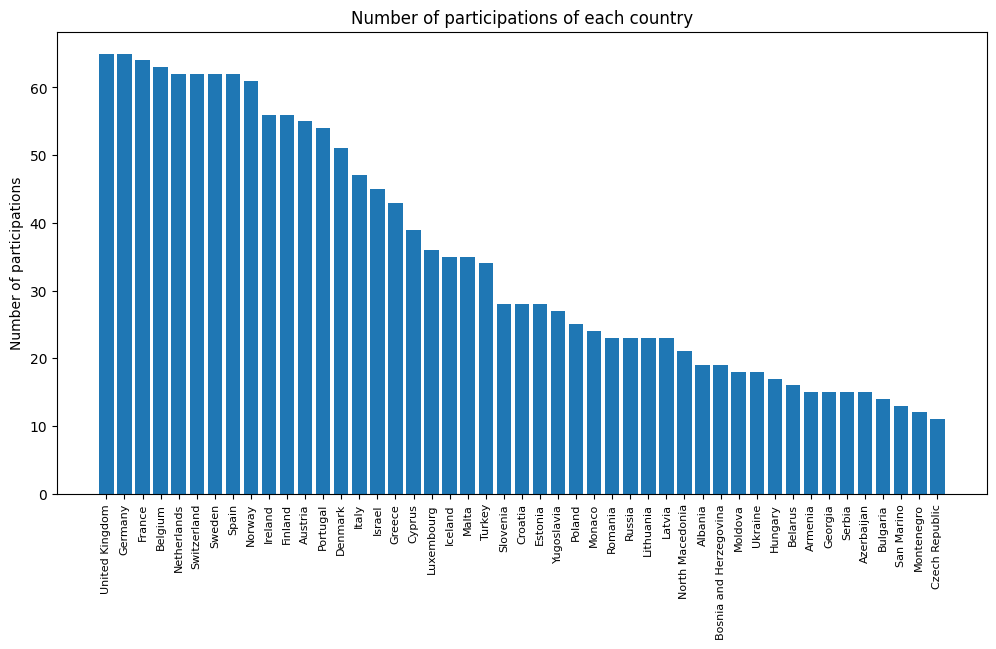

In [158]:
# Plot the number of participations of each country with a minimum of 10 participations
x = participation_counts[participation_counts['participation_count'] >= 10]

plt.figure(figsize=(12, 6))
plt.bar(x['country'], x['participation_count'])
plt.xticks(rotation=90, fontsize=8)    
plt.ylabel('Number of participations')
plt.title('Number of participations of each country')
plt.show()

In [159]:
countries = np.array(participation_counts['country'])
print('Countries:', countries)
print('Number of countries:', len(countries))



Countries: ['United Kingdom' 'Germany' 'France' 'Belgium' 'Netherlands' 'Switzerland'
 'Sweden' 'Spain' 'Norway' 'Ireland' 'Finland' 'Austria' 'Portugal'
 'Denmark' 'Italy' 'Israel' 'Greece' 'Cyprus' 'Luxembourg' 'Iceland'
 'Malta' 'Turkey' 'Slovenia' 'Croatia' 'Estonia' 'Yugoslavia' 'Poland'
 'Monaco' 'Romania' 'Russia' 'Lithuania' 'Latvia' 'North Macedonia'
 'Albania' 'Bosnia and Herzegovina' 'Moldova' 'Ukraine' 'Hungary'
 'Belarus' 'Armenia' 'Georgia' 'Serbia' 'Azerbaijan' 'Bulgaria'
 'San Marino' 'Montenegro' 'Czech Republic' 'Australia' 'Slovakia'
 'Andorra' 'Serbia and Montenegro' 'Morocco' 'World']
Number of countries: 53


### Number of wins

In [160]:
win_table = []
# Get the number of wins of each country by adding the points per year
for year in range(initial_year, final_year + 1):
    
    if year ==2020:
        # No eurovision in 2020
        continue
    df_year = df_final_round[df_final_round['year'] == year]
    table = df_year.groupby('to_country')['total_points'].sum().sort_values(ascending=False)

    if year == 1969:
        # The winner of 1969 was France, Spain, the United Kingdom and the Netherlands (all of the considered winners)
        winners = ['France', 'Spain', 'United Kingdom', 'Netherlands']
    elif year == 1991:
        # The winner was Sweden which draws with France
        winner = table.index[1]
    else:
        winner = table.index[0]
    points = table.iloc[0]
    win_table.append(winner)
    # print(year, winner, points)

# Convert the result to a DataFrame
win_table = pd.DataFrame(win_table, columns=['country'])
win_table = win_table['country'].value_counts().reset_index()
win_table.columns = ['country', 'win_count']

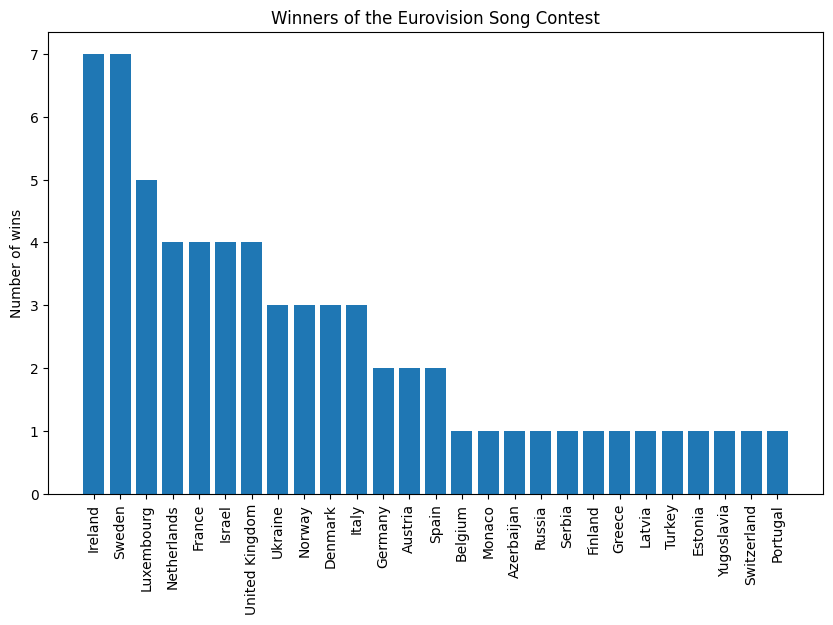

In [161]:

cw = win_table['win_count']
x = win_table['country']

idx_sort = cw.argsort()
cw = cw[idx_sort[::-1]]
x = x[idx_sort[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(x, cw)
plt.xticks(rotation=90)
plt.ylabel('Number of wins')
plt.title('Winners of the Eurovision Song Contest')
plt.show()

In [162]:
# Delete the countries with less than 10 participations
participation_counts = participation_counts[participation_counts['participation_count'] >= 10]

# Update the dataframe
df_final_round = df_final_round[df_final_round['from_country'].isin(participation_counts['country'])]
df_final_round = df_final_round[df_final_round['to_country'].isin(participation_counts['country'])]
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
6,1957,final,at,gb,Austria,United Kingdom,1,NaN,NaN
10,1957,final,be,nl,Belgium,Netherlands,5,NaN,NaN
11,1957,final,be,fr,Belgium,France,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51315,2023,final,gb,am,United Kingdom,Armenia,3,0.0,3.0
51318,2023,final,gb,es,United Kingdom,Spain,5,0.0,5.0
51319,2023,final,gb,md,United Kingdom,Moldova,1,1.0,0.0
51320,2023,final,gb,pl,United Kingdom,Poland,8,8.0,0.0


In [163]:
# Up to year 2015 put the total point given by a country to another country also in the jury points
df_final_round.loc[df_final_round['year'] <= 2015, 'jury_points'] = df_final_round.loc[df_final_round['year'] <= 2015]['total_points']
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,6.0
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,3.0
6,1957,final,at,gb,Austria,United Kingdom,1,NaN,1.0
10,1957,final,be,nl,Belgium,Netherlands,5,NaN,5.0
11,1957,final,be,fr,Belgium,France,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...
51315,2023,final,gb,am,United Kingdom,Armenia,3,0.0,3.0
51318,2023,final,gb,es,United Kingdom,Spain,5,0.0,5.0
51319,2023,final,gb,md,United Kingdom,Moldova,1,1.0,0.0
51320,2023,final,gb,pl,United Kingdom,Poland,8,8.0,0.0


### Country analyzer

#### One country analyzer

Number of points given by Spain before 1997 and after 1997 + Boxplot of normalized points

In [164]:
# Function to obtain the number of points given for a given country during a time period

def family_points(df_final_round, country_id, initial_year, crop=20):
    
    # Get the number of points given by country_id to each country
    friends = df_final_round.query(f'year >= {initial_year} and from_country=="{country_id}"')
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
    gs = axs[1,0].get_gridspec()
    for ax in axs[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1,:])
    
    def normalize(df):
        return df / df.sum()
    
    fig.suptitle(f'Normalized points given by {country_id} to each country since {initial_year}', fontsize=16)
    # fig.tight_layout()


    # Plot the  normalized number of jury points given by country_id to each country
    friends1 = friends.groupby('to_country')['jury_points'].sum().sort_values(ascending=False)
    indices = friends1.index
    indices = indices[:crop]
    friends1 = normalize(friends1)
    friends1 = friends1.reset_index()
    friends1.columns = ['country', 'points']
    friends1 = friends1.head(crop)
    x = friends1['country']
    y = friends1['points']
    axs[0,0].bar(x, y, label='Jury')
    # axs[0,0].set_title(f'Normalized points given by {country_id} to each country')
    axs[0,0].set_xticklabels(x, rotation=90, fontsize=8)
    axs[0,0].set_ylabel('Normalized points')
    axs[0,0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    
    # Plot the number of televote points given by country_id to each country
    friends2 = friends.groupby('to_country')['tele_points'].sum().sort_values(ascending=False)
    friends2 = friends2 / friends2.sum()
    friends2 = friends2.reset_index()
    friends2.columns = ['country', 'points']
    friends2 = friends2.head(crop)
    x = friends2['country']
    y = friends2['points']
    axs[0,1].bar(x, y, label='Televote', color='orange')
    # axs[0,1].set_title(f'Normalized Points given by {country_id} to each country')
    axs[0,1].set_xticklabels(x, rotation=90, fontsize=8)
    axs[0,1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    
    # Boxplot of the total points given by country_id to each country though the years
    friends_sorted = friends.groupby('year').apply(lambda x: normalize(x.groupby('to_country')['jury_points'].sum())).reset_index()
    # t = friends_sorted.groupby('to_country').sum().sort_values('jury_points', ascending=False).index
    # t = t[:crop]
    
    sns.boxplot(data=friends_sorted[friends_sorted['to_country'].isin(indices)], x='to_country', y='jury_points', order=indices, ax=axbig, color='skyblue')
    axbig.set_xticklabels(axbig.get_xticklabels(), rotation=90, fontsize=8)
    axbig.set_ylabel('Normalized points')
    axbig.set_title(f'Jury Point distribution though the years')
    axbig.set_xlabel('')
    
    
    plt.subplots_adjust(hspace=0.6)  # Adjust the spacing (increase for more space)

    plt.show()
    
    
    return 


C:\Users\mate1\AppData\Local\Temp\ipykernel_4804\384718967.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x, rotation=90, fontsize=8)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4804\384718967.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x, rotation=90, fontsize=8)
C:\Users\mate1\AppData\Local\Temp\ipykernel_4804\384718967.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axbig.set_xticklabels(axbig.get_xticklabels(), rotation=90, fontsize=8)


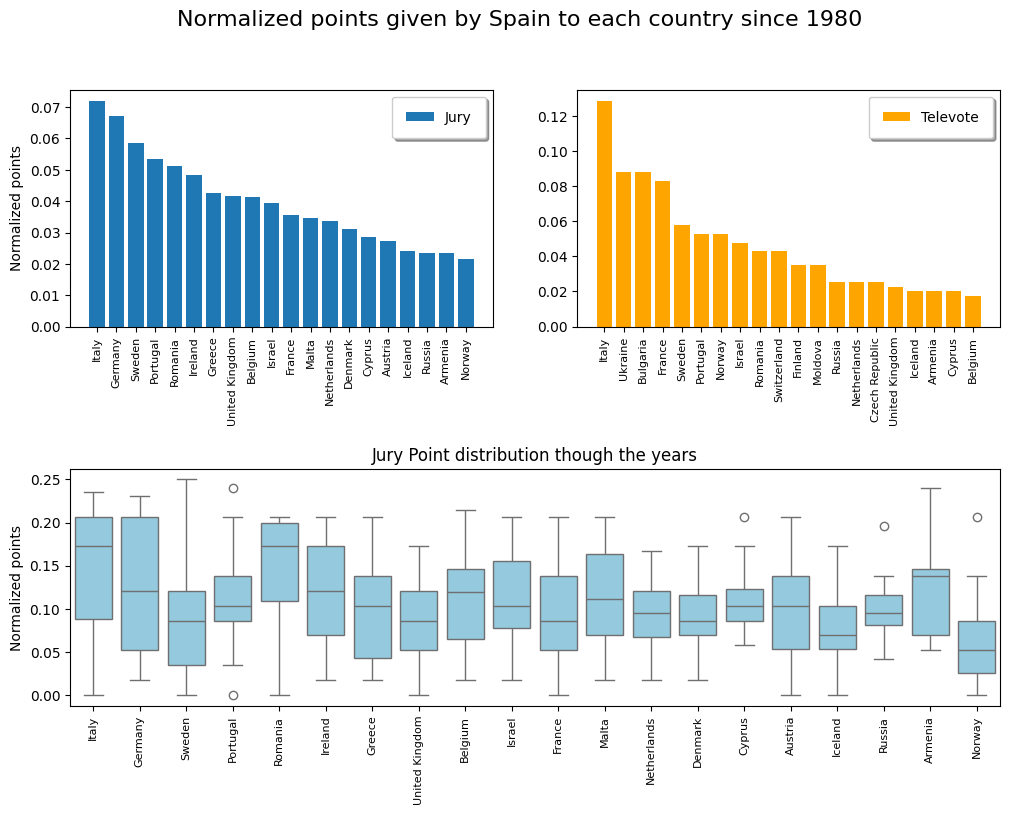

In [165]:
family_points(df_final_round, country_id='Spain', initial_year=1980)

## Analysis

### Tree diagram of cohesion cluster analysis

In [256]:
# Cluster analysis by applying Ward algorithm and Squared Euclidean distance
from scipy.cluster.hierarchy import dendrogram, linkage

def cluster_analysis(df, initial_year, final_year, N_top=20):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    
    # Fin the top N countries during the time period
    top_countries = df_filtered['from_country'].value_counts().index[:N_top]
    
    # Normalize the jury points
    # Obtain the total points given by each country to each other
    total_points = df_filtered.groupby(['from_country', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Normalize the points
    total_points = total_points.apply(lambda x: x / x.sum(), axis=1)
    
    # Create an interaction matrix for the top countries
    interaction_matrix = pd.DataFrame(0.0, index=top_countries, columns=top_countries)
        
    # Fill the matrix with the average normalized points given by each country to each other
    for country in top_countries:
        interaction_matrix.loc[country] = total_points.loc[country]
    
    interaction_matrix = interaction_matrix.fillna(0)
    
    # Apply the Ward algorithm and Squared Euclidean distance
    Z = linkage(interaction_matrix, 'ward', metric='euclidean')
    
    # Plot the dendrogram and correlation matrix
    plt.figure(figsize=(12, 6))
    
    # Plot the dendrogram
    dendrogram(Z, labels=interaction_matrix.index, orientation='right')
    plt.title(f'Dendrogram of the top countries from {initial_year} to {final_year}')
    plt.show()

    return

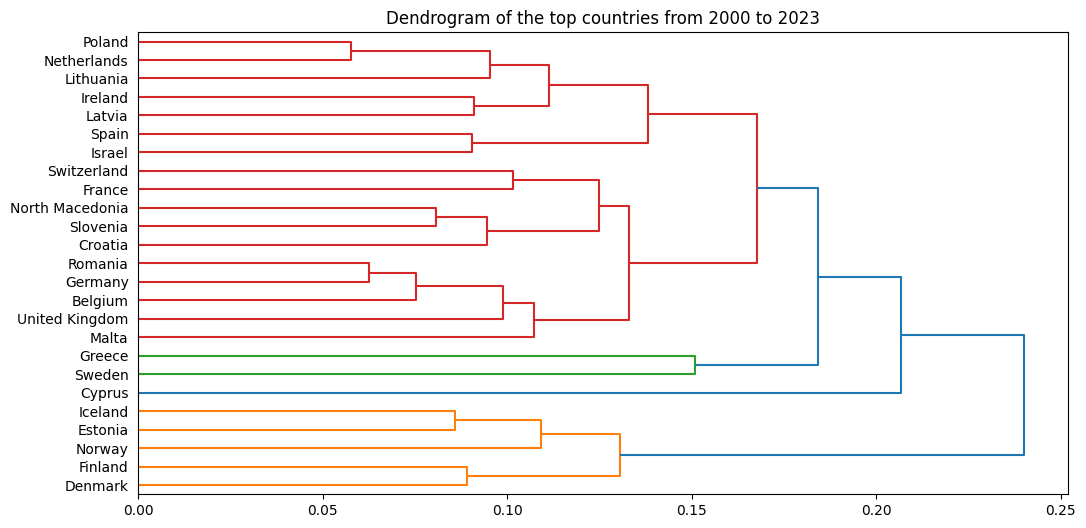

In [ ]:
cluster_analysis(df_final_round, initial_year=1998, final_year=2023, N_top=25)

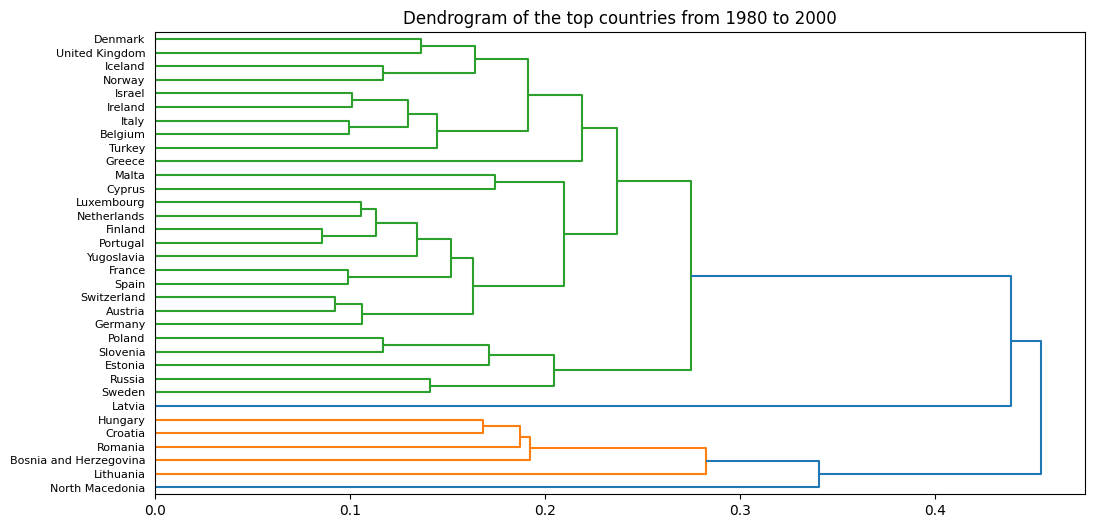

In [ ]:
cluster_analysis(df_final_round, initial_year=1980, final_year=1997, N_top=50)

In this cluster analysis we compare the voting portfolios between countries for different range of years, by applying the Wards method and euclidean distance which produce the least biased results. The Warts method seeks to minimize the total within-cluster variance as clusters are merged. At each step of the algorithm:

- It computes the increase in total within-cluster variance that would result from merging any two clusters.
- It selects the pair of clusters whose merging causes the smallest increase in this variance.

This leads to a hierarchy of clusters, visualized as a dendrogram.

In [ ]:
# Cluster groups of countries


### Network

### Study of Bias

We define quality as the average aggregate number of points from all the other country juries to song $C_j$ in year $t$:

$$\text{Quality}\quad C_{jt} = \frac{1}{p-2}\sum_{p\neq i,j} C_{ijt}$$

Thenb, the bias is defined as:

$$\text{Bias} \, C_{ijt} = \text{Vote} \, C_{ijt} - \text{Quality} \, C_{jt}$$

In [401]:
def bias_dyads(df, initial_year, final_year):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['to_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)
    
    # Compute the average bias of each country to each other and store the 10 most biased dyads
    bias = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)

    for country in given_points_yearly.columns:
        for country2 in given_points_yearly.columns:
            if country != country2:
                total_bias = 0
                count = 0
                for year in participants.index:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        
                        # Compute bias for this year
                        b = points_between - quality.loc[year, country2]
                        total_bias += b
                        count += 1
                if count > 0:
                    bias.loc[country, country2] = total_bias / count
    
    # Ensure index and column names are correctly set at this stage
    bias.index.name = 'from_country'
    bias.columns.name = 'to_country'
    bias.index = bias.index.rename('from_country')
    
    # Now stack the DataFrame (this will not overwrite the index names)
    bias_stacked = bias.stack().reset_index(name='bias')

    # Rename columns for clarity
    bias_stacked.columns = ['Voter', 'Reciever', 'bias']

    # Sort and select the top 10 most biased dyads
    bias_stacked = bias_stacked.sort_values('bias', ascending=False).head(10)
    
    #p value
    p_values = []
    for i in range(10):
        country1 = bias_stacked.iloc[i]['Voter']
        country2 = bias_stacked.iloc[i]['Reciever']
        p_value = ttest_ind(df_filtered[(df_filtered['from_country'] == country1) & (df_filtered['to_country'] == country2)]['jury_points'], df_filtered[(df_filtered['from_country'] == country2) & (df_filtered['to_country'] == country1)]['jury_points']).pvalue
        p_values.append(p_value)
        
    bias_stacked['p_value'] = p_values

    return bias_stacked




Revisar p_value

In [405]:
import numpy as np
import pandas as pd
from scipy import stats

def bias_dyads(df, initial_year, final_year, n_permutations=1000):
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['to_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)
    
    # Compute the average bias of each country to each other
    bias = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    for country in given_points_yearly.columns:
        for country2 in given_points_yearly.columns:
            if country != country2:
                total_bias = 0
                count = 0
                for year in participants.index:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        
                        # Compute bias for this year
                        b = points_between - quality.loc[year, country2]
                        total_bias += b
                        count += 1
                if count > 0:
                    bias.loc[country, country2] = total_bias / count
    
    # Perform the t-test for p-values using scipy
    p_values = pd.DataFrame(index=bias.index, columns=bias.columns)

    for country in bias.index:
        for country2 in bias.columns:
            if country != country2:
                observed_bias = bias.loc[country, country2]
                
                # Get the bias values across all years
                all_biases = []
                for year in participants.index:
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        b = points_between - quality.loc[year, country2]
                        all_biases.append(b)

                # Perform the t-test for the observed bias
                t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)
                p_values.loc[country, country2] = p_value
    
    # Ensure index and column names are set correctly
    bias.index.name = 'from_country'
    bias.columns.name = 'to_country'
    bias.index = bias.index.rename('from_country')
    
    p_values.index.name = 'from_country'
    p_values.columns.name = 'to_country'
    p_values.index = p_values.index.rename('from_country')

    # Reset index and reshape the DataFrame using .melt()
    bias_reset = bias.reset_index().melt(id_vars=['from_country'], value_vars=bias.columns, var_name='to_country', value_name='bias')
    p_values_reset = p_values.reset_index().melt(id_vars=['from_country'], value_vars=p_values.columns, var_name='to_country', value_name='p_value')

    # Merge the bias and p-value dataframes
    result = pd.merge(bias_reset, p_values_reset, on=['from_country', 'to_country'])

    # Sort and select the top 10 most biased dyads
    result = result.sort_values('bias', ascending=False).head(10)

    return result


In [409]:
bias_dyads(df_final_round, initial_year=1998, final_year=2023)

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Lo

,from_country,to_country,bias,p_value
1224,Serbia,Montenegro,10.000000,NaN
1611,Montenegro,Serbia,9.818182,NaN
413,Greece,Cyprus,9.349753,0.0
27,Montenegro,Albania,8.454545,NaN
1189,Armenia,Montenegro,8.229167,0.16841
757,Cyprus,Greece,7.803552,0.000032
29,North Macedonia,Albania,7.309394,0.003961
1177,Romania,Moldova,6.992631,0.000111
890,Czech Republic,Ireland,6.956522,NaN
1225,Slovenia,Montenegro,6.729167,0.118829


In [390]:
bias_dyads(df_final_round, initial_year=1957, final_year=1997)

,Voter,Reciever,bias
138,Cyprus,Greece,8.116204
486,Italy,Estonia,8.095238
324,Greece,Cyprus,6.551587
930,Turkey,Bosnia and Herzegovina,6.365450
745,Romania,Germany,6.238095
235,Finland,Hungary,6.190476
753,Romania,Malta,5.857143
567,Malta,Romania,5.333333
343,Greece,Romania,5.333333
113,Croatia,Malta,5.259048


### The effect of centrality

### Hypothesis test